In [1]:
from itertools import product

import numpy as np
import xarray as xr
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import util
plt.style.use('ggplot')


In [2]:
variables = ['SST', 'Chl_surf', 'KGP']

ds_djf = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds_djf_regional = ds_djf[variables].sel(length = 40).sel(region = 'Southern Ocean')
ds_djf_regional

<xarray.Dataset>
Dimensions:    (member_id: 34, time: 180)
Coordinates:
    region     <U17 'Southern Ocean'
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    length     float64 40.0
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
Data variables:
    SST        (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    Chl_surf   (time, member_id) float64 dask.array<chunksize=(180, 34), meta=np.ndarray>
    KGP        (time, member_id) float64 dask.array<chunksize=(90, 34), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [3]:
ds_ref_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
ds_ref_mean

<xarray.Dataset>
Dimensions:        (length: 3, region: 5)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
  * region         (region) <U17 'Southern Ocean' ... 'AP Sector'
Data variables:
    Chl_surf       (region) float64 0.7665 1.003 1.244 0.9447 0.7665
    IFRAC          (region) float64 0.1192 0.1575 0.1635 0.1509 0.1192
    KGP            (length, region) float64 0.02202 0.02735 ... -0.02046
    KGP_bias_corr  (length, region) float64 0.04688 0.05663 ... -0.01229
    SST            (region) float64 4.782 4.31 4.44 4.408 4.782
    SST_bias_corr  (region) float64 4.393 3.747 3.881 3.861 4.393

Standard deviation of anomalies

In [4]:
ds_ref_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
ds_ref_std

<xarray.Dataset>
Dimensions:        (length: 3, region: 5)
Coordinates:
  * length         (length) float64 20.0 40.0 60.0
  * region         (region) <U17 'Southern Ocean' ... 'AP Sector'
Data variables:
    Chl_surf       (region) float64 0.04342 0.09069 0.1197 0.08233 0.04342
    IFRAC          (region) float64 0.006241 0.01108 0.01487 0.01019 0.006241
    KGP            (length, region) float64 0.002902 0.003494 ... 0.001869
    KGP_bias_corr  (length, region) float64 0.003248 0.004376 ... 0.002343
    SST            (region) float64 0.1896 0.1848 0.2251 0.1817 0.1896
    SST_bias_corr  (region) float64 0.09917 0.1058 0.1385 0.09796 0.09917

### compute the anomalies relative to the reference

Text(0.5, 1.0, 'Daily growth rate anomaly ')

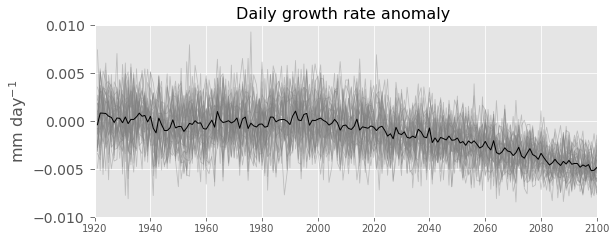

In [5]:
###########   As a Plot  ##############
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
v = 'KGP'
limYMin, limYMax = -0.01, 0.01
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id)
    ref_i = ds_djf_regional[v].sel(member_id=m_id).sel(time=slice('1920', '1950')).mean(['time'])
    anom = var_i - ref_i
    ax.plot(ds_djf_regional.time, anom,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)

forced = ds_djf_regional[v].mean('member_id')     
ref = ds_djf_regional[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])
anom_f = forced - ref

ax.plot(ds_djf_regional.time, anom_f,'-', linewidth=1, color='k')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf_regional[v].long_name} anomaly ', fontsize = 16)

In [6]:
v = 'KGP'
forced = ds_djf_regional[v].mean('member_id')     
ref = ds_djf_regional[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])
anom_f = forced - ref
# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
# Values to integrate.
y = anom_f.values
# The coordinate to integrate along.
x = anom_f['time']
# dx = Spacing between elements of y. Only used if x is None.
# axis = Specifies the axis to cumulate. Default is -1 (last axis)
# initial = If given, insert this value at the beginning of the returned result. Typically this value should be 0. 
# Default is None, which means no value at x[0] is returned and res has one element less than y along the axis of integration.
initial = 0  
y_int = integrate.cumtrapz(y, x, initial = initial)

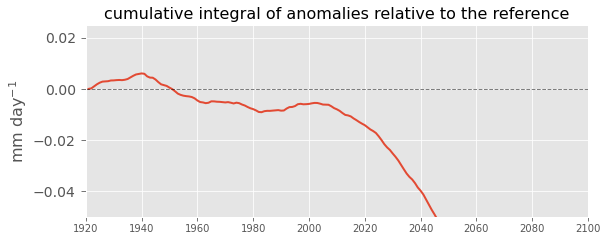

In [7]:
title = 'cumulative integral of anomalies relative to the reference'
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim([-.05, .025])
ax.plot(x, y_int, linewidth = 2)
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(title, fontsize = 16);

In [8]:
v = 'SST'
forced = ds_djf_regional[v].mean('member_id')     
ref = ds_djf_regional[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])
anom_f = forced - ref

# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
y = anom_f.values # Values to integrate.
x = anom_f['time'] # The coordinate to integrate along.
initial = 0 # initial = If given, insert this value at the beginning of the returned result. Typically this value should be 0. 
y_int = integrate.cumtrapz(y, x, initial = initial)

Text(0.5, 1.0, 'Potential Temperature anomaly cumulative integral')

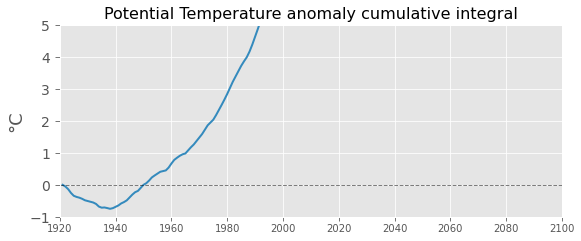

In [9]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim([-1, 5])
ax.plot(x, y_int, color='C1', linewidth = 2)
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf_regional[v].long_name} anomaly cumulative integral', fontsize = 16)

In [10]:
v = 'Chl_surf'
forced = ds_djf_regional[v].mean('member_id')     
ref = ds_djf_regional[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])
anom_f = forced - ref

# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
y = anom_f.values # Values to integrate.
x = anom_f['time'] # The coordinate to integrate along.
initial = 0 # initial = If given, insert this value at the beginning of the returned result. Typically this value should be 0. 
y_int = integrate.cumtrapz(y, x, initial=initial)


In [45]:
y_int = xr.full_like(anom_f, fill_value=0)
y_int.values = integrate.cumtrapz(y, x, initial=initial)

Text(0.5, 1.0, 'Surface chlorophyll anomaly cumulative integral')

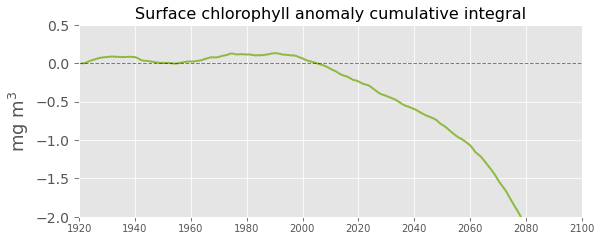

In [11]:
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim([-2, .5])
ax.plot(x, y_int, color='C5', linewidth = 2)
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title(f'{ds_djf_regional[v].long_name} anomaly cumulative integral', fontsize = 16)

In [12]:
v = 'KGP'
ref = ds_djf_regional[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])
anom_k = ds_djf_regional[v].mean('member_id')  - ref
# Cumulatively integrate mm day(years) using the composite trapezoidal rule.
y_k = anom_k.values # Values to integrate.
x = anom_k['time'].values # The coordinate to integrate along.
initial = 0 # initial = If given, insert this value at the beginning of the returned result. Typically this value should be 0. 
y_int_k = integrate.cumtrapz(y_k, x, initial = initial)
thresh_k = np.max(np.where(y_int_k>0))

v = 'SST'
ref = ds_djf_regional[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])
anom_t = ds_djf_regional[v].mean('member_id')  - ref
y_t = anom_t.values # Values to integrate.
y_int_t = integrate.cumtrapz(y_t, x, initial = initial)
thresh_t = np.min(np.where(y_int_t>0))

v = 'Chl_surf'
ref = ds_djf_regional[v].sel(time=slice('1920', '1950')).mean(['member_id', 'time'])
anom_c = ds_djf_regional[v].mean('member_id')  - ref
y_c = anom_c.values # Values to integrate.
y_int_c = integrate.cumtrapz(y_c, x, initial = initial)
thresh_c = np.max(np.where(y_int_c>0))

print('krill:', thresh_k,'chl:', thresh_c,'temp:', thresh_t)

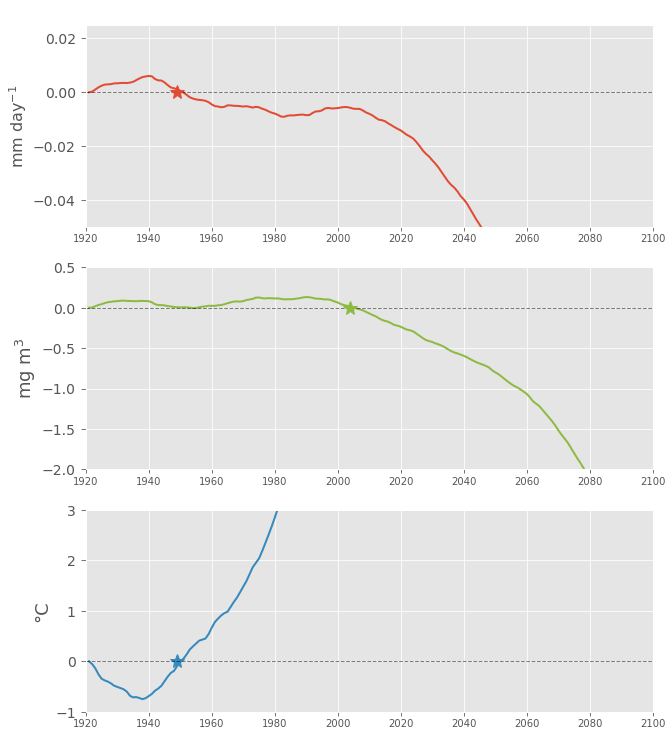

In [20]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim([-.05, .025])
ax.plot(x, y_int_k, linewidth = 2)
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
ax.plot(1920+thresh_k, 0, 'r*', markersize=15, color = 'C0')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mm day$^{-1}$', fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = 'cumulative integral of anomalies relative to the reference'
ax.set_title(title, fontsize = 16);
#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)
ax.set_ylim([-1, 3])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.plot(x, y_int_t, color='C1', linewidth = 2)
ax.plot(1920+thresh_t, 0, 'r*', markersize=15, color='C1')
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('°C', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('SST anomaly cumulative integral', fontsize = 16)
#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
ax.set_ylim([-2, .5])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.plot(x, y_int_c, color='C5', linewidth = 2)
ax.axhline(0, lw=1, color='k', linestyle='--', alpha = .5)
ax.plot(1920+thresh_c, 0, 'r*', markersize=15, color='C5')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylabel('mg m$^3$', fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
ax.set_title('Chl anomaly cumulative integral', fontsize = 16)
#####################################
gs.update(hspace=.2, top=.92, right =1)

# title = ('cumulative integrals dark')
# path = 'figures/'
# file = '.pdf'
# plt.savefig(path + title + file, bbox_inches='tight')

### Find inflection point?  Find values above zero

In [34]:
# Turn it back into an xarray data array and mask the values to calculate a trend on
int_da_k= xr.DataArray(y_int_k,  dims='time')
cc_mask_k = int_da_k.where(int_da_k < 0)
# SST
# Turn it back into an xarray data array and mask the values to calculate a trend on
int_da_t= xr.DataArray(y_int_t,  dims='time')
cc_mask_t = int_da_t.where(int_da_t > 0)
# Chl
# Turn it back into an xarray data array and mask the values to calculate a trend on
int_da_c= xr.DataArray(y_int_c,  dims='time')
cc_mask_c = int_da_c.where(int_da_c < 0)

In [41]:
test_da = util.linear_trend(cc_mask_c)      
test_da

<xarray.DataArray ()>
dask.array<vectorize_calc_slope, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

### define inflection point

In [17]:
#Compute the sign of the forced trend
ds_trend_sign = y_int_t[-1:]

# Compute the value of the threshold for ToE
ds_toe_threshold = y_int_t.where(y_int_t>0)

# Compute the time-evolving 2 𝜎  timeseries
ds_2sigma = ds_djf.mean('member_id') #+ 2. * ds_trend_sign * ds_djf.std('member_id')
ds_2sigma = ds_2sigma.compute()
ds_2sigma_neg = ds_djf.mean('member_id') - 2. * ds_trend_sign * ds_djf.std('member_id')
ds_2sigma_neg = ds_2sigma_neg.compute()


SyntaxError: invalid syntax (<ipython-input-17-27b269f70fdd>, line 5)

In [ ]:
 ds_ctrl_mean + 2. * ds_ctrl_std * ds_trend_sign

### Identify where climate change has started

In [ ]:
%%time
ds_x_thresh = xr.where(ds_trend_sign > 0,
               ds_2sigma > ds_toe_threshold,
               ds_2sigma < ds_toe_threshold,               
               ).compute()
ds_x_thresh

<xarray.DataArray (time: 180)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan, -3.61892699e-03, -2.69835299e-03,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan, -1.04993340e-02, -2.04636997e-02, -3.30585590e-02,
       -5.21419607e-02, -7.21497537e-02, -8.90075099e-02, -1.05127215e-01,
       -1.29337020e-01, -1.49540315e-01, -1.63170162e-01, -1.72983811e-01,
       -1.92060489e-01, -2.13725953e-01, -2.22106359e-01, -2.35057495e-01,
       -2.55045761e-01, -2.70836393e-01, -2.79407893e-01, -2.93746169e-01,
       -3.21014965e-01, -3.48487160e-01, -3.75840042e-01, -3.99543363e-01,
       -4.11774582e-01, -4.23893655e-01, -4.40048051e-01, -4.53590062e-01,
       -4.69256600e-01, -4.89306007e-01, -5.13810483e-01, -5.36606498e-01,
       -5.53703935e-01, -5.65325041e-01, -5.79438737e-01, -5.95087625e-01,
       -6.12511725e-01, -6.35048405e-01, -6.53972812e-01, -6.74015622e-01,
       -6.89670224e-01, -7.04025177e-01, -7.19111459e-01, -7.38538303e-01,
       -7.73787947e-01, -7.99831812e-01, -8.20983427e-01, -8.52244987e-01,
       -8.84030317e-01, -9.14017009e-01, -9.42619046e-01, -9.67419907e-01,
       -9.85919306e-01, -1.01064376e+00, -1.03804361e+00, -1.06566620e+00,
       -1.10824433e+00, -1.15827330e+00, -1.18878761e+00, -1.21765178e+00,
       -1.26308015e+00, -1.30827886e+00, -1.35543505e+00, -1.40242556e+00,
       -1.45474755e+00, -1.51453126e+00, -1.57001684e+00, -1.61764789e+00,
       -1.66912465e+00, -1.73292583e+00, -1.79914857e+00, -1.86058534e+00,
       -1.91847418e+00, -1.98320279e+00, -2.05308843e+00, -2.12098974e+00,
       -2.18778453e+00, -2.25712032e+00, -2.33561465e+00, -2.42033737e+00,
       -2.50518290e+00, -2.59032911e+00, -2.67845136e+00, -2.77264694e+00,
       -2.86731211e+00, -2.95017387e+00, -3.03311941e+00, -3.12464207e+00,
       -3.21691225e+00, -3.31368606e+00, -3.41220784e+00, -3.50817720e+00,
       -3.60551078e+00, -3.71361596e+00, -3.82441426e+00, -3.92898376e+00])
Dimensions without coordinates: time